## Introduction

In this notebook, we will learn how to use [LoRA](https://arxiv.org/abs/2106.09685) from 🤗 PEFT to fine-tune a SegFormer model variant for semantic segmentation by ONLY using **14%** of the original trainable parameters of the model. 

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://arxiv.org/abs/2106.09685). 

Let's get started by installing the dependencies. 

## Install dependencies

Here we're installing `peft` from source to ensure we have access to all the bleeding edge features of `peft`. 

In [ ]:
!pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

## Authentication

We will share our fine-tuned model at the end of training. So, to do that we just authenticate using our 🤗 token. This token is available from [here](https://huggingface.co/settings/tokens). If you don't have a 🤗 account already, we highly encourage you to do so; it's free!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load a dataset

We're only loading the first 150 instances from the training set of the [SceneParse150 dataset](https://huggingface.co/datasets/scene_parse_150) to keep this example runtime short. 

In [ ]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:150]")

## Prepare train and test splits

In [2]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

## Prepare label mappers

We create two dictionaries:

* `label2id`: maps the semantic classes of the dataset to integer ids.
* `id2label`: `label2id` reversed. 

In [ ]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

## Prepare datasets for training and evaluation

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

In [5]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [6]:
from PIL import Image
import numpy as np


def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)


def train_transforms(example_batch):
    images = [jitter(handle_grayscale_image(x)) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [handle_grayscale_image(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [7]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Evaluation function

Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load a evaluation method with the [🤗 Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [mean Intersection over Union (IoU)](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [12]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.reduce_labels,
        )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

## Load a base model

For this example, we use the [SegFormer B0 variant](https://huggingface.co/nvidia/mit-b0). 

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

We pass the `label2id` and `id2label` dictionaries to let the `AutoModelForSemanticSegmentation` class know that we're interested in a custom base model where the decoder head should be randomly initialized w.r.t our custom dataset. Note, however, that the rest of the model parameters are pre-trained and will be fine-tuned in a regular transfer learning setup.

We also notice that the 100% parameters in the `model` are trainable. 

In [ ]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
print_trainable_parameters(model)

## Wrap `model` as a `PeftModel` for LoRA training

This involves two steps:

* Defining a config with `LoraConfig`
* Wrapping the original `model` with `get_peft_model()` with the config defined in the step above. 

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
trainable params: 564374 || all params: 3883766 || trainable%: 14.53


 Let's unpack what's going on here. 

In order for LoRA to take effect, we need to specify the target modules to `LoraConfig` so that `PeftModel` knows which modules inside our model needs to be amended with LoRA matrices. In this case, we're only interested in targetting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" with `query` and `value` respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`. 

We also specify `modules_to_save`. After we wrap our base model `model` with `PeftModel` along with the `config`, we get a new model where only the LoRA parameters are trainable (so-called "update matrices") while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.  

Regarding the other parameters:

* `r`: The dimension used by the LoRA update matrices.
* `alpha`: Scaling factor.
* `bias`: Specifying if the `bias` parameters should be trained. `lora_only` denotes only the LoRA `bias` parameters will be trained. 

`r` and `alpha` together control the total number of final trainable parameters when using LoRA giving us the flexbility to balance a trade-off between end performance and compute efficiency.


We can also how many parameters we're actually training. Since we're interested in performing **parameter-efficient fine-tuning**, we should expect to notice a less number of trainable parameters from the `lora_model` in comparison to the original `model` which is indeed the case here. 

For sanity, let's also manually verify the modules that are actually trainable in `lora_model`. 

In [16]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_A.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_B.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_A.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_B.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_A.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_B.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.lora_A.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.lora_B.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.1.0.attention.self.query.lora_A.weight torch.Size([32, 64])
base_model.model.segformer.encoder.block.1.0.attention.self.query.lora_B.weight torch.Size(

We can confirm that only the LoRA parameters appended to the attention blocks and the `decode_head` parameters are trainable.

## Train!

This is a two-step process: 

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.TrainingArguments). It is important you don’t remove unused columns because this’ll drop the image column. Without the image column, you can’t create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is output_dir which specifies where to save your model. At the end of each epoch, the `Trainer` will evaluate the IoU metric and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call `train()` to finetune your model.


**Note** that This example is meant to walk you through the workflow when using PEFT for semantic segmentation. We didn't perform extensive hyperparameter tuning to achieve optimal results. 

In [ ]:
model_name = checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-scene-parse-150-lora",
    learning_rate=5e-4,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

## Saving the model and inference 

Here we use the `save_pretrained()` method of the `lora_model` to save the *LoRA-only parameters* locally. However, you can also use thr `push_to_hub()` method to upload these parameters directly to the Hugging Face Hub (as shown [here](https://colab.research.google.com/github/huggingface/peft/blob/main/examples/image_classification/image_classification_peft_lora.ipynb)). 

In [18]:
model_id = "segformer-scene-parse-150-lora"
lora_model.save_pretrained(model_id)

We can see that the LoRA-only parameters are just **2.2 MB in size**! This greatly improves the portability when using very large models. 

In [19]:
!ls -lh {model_id}

total 2.2M
-rw-r--r-- 1 root root  369 Feb  8 03:09 adapter_config.json
-rw-r--r-- 1 root root 2.2M Feb  8 03:09 adapter_model.bin


Let's now prepare our `inference_model` and run an inference. 

In [ ]:
from peft import PeftConfig

config = PeftConfig.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, model_id)

Fetch an image.

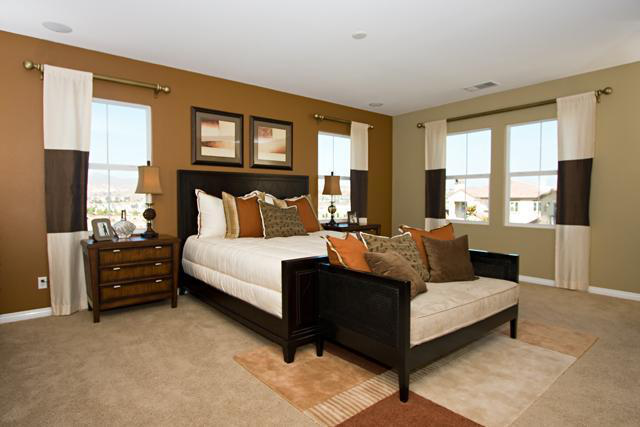

In [26]:
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png"
image = Image.open(requests.get(url, stream=True).raw)
image

Preprocess the image.

In [28]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 512, 512])


Run an inference. 

In [29]:
with torch.no_grad():
    outputs = inference_model(pixel_values=encoding.pixel_values)
    logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

Visualize the results.

We need a color palette to visualize the results. Here, we use [one provided by the TensorFlow Model Garden repository](https://github.com/tensorflow/models/blob/3f1ca33afe3c1631b733ea7e40c294273b9e406d/research/deeplab/utils/get_dataset_colormap.py#L51).

In [30]:
def ade_palette():
    """Creates a label colormap used in ADE20K segmentation benchmark.
    Returns:
    A colormap for visualizing segmentation results.
    """
    return np.asarray(
        [
            [0, 0, 0],
            [120, 120, 120],
            [180, 120, 120],
            [6, 230, 230],
            [80, 50, 50],
            [4, 200, 3],
            [120, 120, 80],
            [140, 140, 140],
            [204, 5, 255],
            [230, 230, 230],
            [4, 250, 7],
            [224, 5, 255],
            [235, 255, 7],
            [150, 5, 61],
            [120, 120, 70],
            [8, 255, 51],
            [255, 6, 82],
            [143, 255, 140],
            [204, 255, 4],
            [255, 51, 7],
            [204, 70, 3],
            [0, 102, 200],
            [61, 230, 250],
            [255, 6, 51],
            [11, 102, 255],
            [255, 7, 71],
            [255, 9, 224],
            [9, 7, 230],
            [220, 220, 220],
            [255, 9, 92],
            [112, 9, 255],
            [8, 255, 214],
            [7, 255, 224],
            [255, 184, 6],
            [10, 255, 71],
            [255, 41, 10],
            [7, 255, 255],
            [224, 255, 8],
            [102, 8, 255],
            [255, 61, 6],
            [255, 194, 7],
            [255, 122, 8],
            [0, 255, 20],
            [255, 8, 41],
            [255, 5, 153],
            [6, 51, 255],
            [235, 12, 255],
            [160, 150, 20],
            [0, 163, 255],
            [140, 140, 140],
            [250, 10, 15],
            [20, 255, 0],
            [31, 255, 0],
            [255, 31, 0],
            [255, 224, 0],
            [153, 255, 0],
            [0, 0, 255],
            [255, 71, 0],
            [0, 235, 255],
            [0, 173, 255],
            [31, 0, 255],
            [11, 200, 200],
            [255, 82, 0],
            [0, 255, 245],
            [0, 61, 255],
            [0, 255, 112],
            [0, 255, 133],
            [255, 0, 0],
            [255, 163, 0],
            [255, 102, 0],
            [194, 255, 0],
            [0, 143, 255],
            [51, 255, 0],
            [0, 82, 255],
            [0, 255, 41],
            [0, 255, 173],
            [10, 0, 255],
            [173, 255, 0],
            [0, 255, 153],
            [255, 92, 0],
            [255, 0, 255],
            [255, 0, 245],
            [255, 0, 102],
            [255, 173, 0],
            [255, 0, 20],
            [255, 184, 184],
            [0, 31, 255],
            [0, 255, 61],
            [0, 71, 255],
            [255, 0, 204],
            [0, 255, 194],
            [0, 255, 82],
            [0, 10, 255],
            [0, 112, 255],
            [51, 0, 255],
            [0, 194, 255],
            [0, 122, 255],
            [0, 255, 163],
            [255, 153, 0],
            [0, 255, 10],
            [255, 112, 0],
            [143, 255, 0],
            [82, 0, 255],
            [163, 255, 0],
            [255, 235, 0],
            [8, 184, 170],
            [133, 0, 255],
            [0, 255, 92],
            [184, 0, 255],
            [255, 0, 31],
            [0, 184, 255],
            [0, 214, 255],
            [255, 0, 112],
            [92, 255, 0],
            [0, 224, 255],
            [112, 224, 255],
            [70, 184, 160],
            [163, 0, 255],
            [153, 0, 255],
            [71, 255, 0],
            [255, 0, 163],
            [255, 204, 0],
            [255, 0, 143],
            [0, 255, 235],
            [133, 255, 0],
            [255, 0, 235],
            [245, 0, 255],
            [255, 0, 122],
            [255, 245, 0],
            [10, 190, 212],
            [214, 255, 0],
            [0, 204, 255],
            [20, 0, 255],
            [255, 255, 0],
            [0, 153, 255],
            [0, 41, 255],
            [0, 255, 204],
            [41, 0, 255],
            [41, 255, 0],
            [173, 0, 255],
            [0, 245, 255],
            [71, 0, 255],
            [122, 0, 255],
            [0, 255, 184],
            [0, 92, 255],
            [184, 255, 0],
            [0, 133, 255],
            [255, 214, 0],
            [25, 194, 194],
            [102, 255, 0],
            [92, 0, 255],
        ]
    )

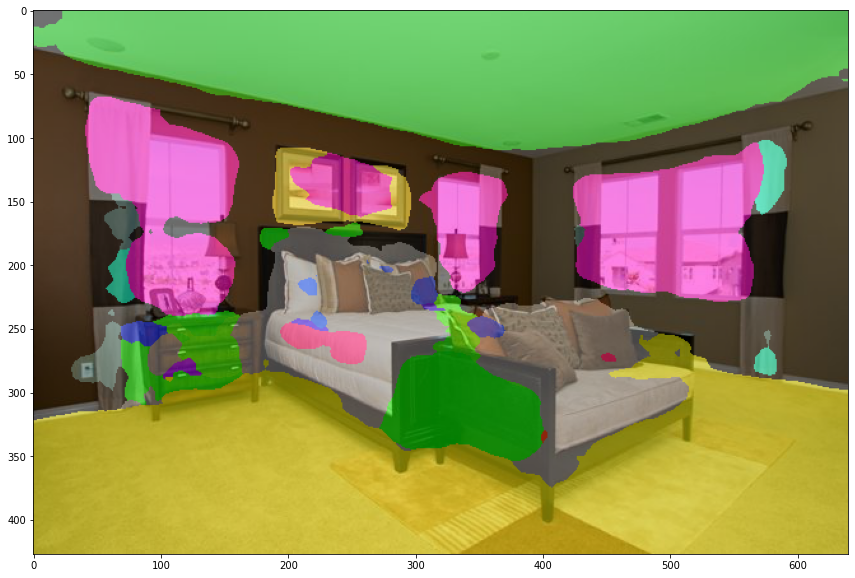

In [31]:
import matplotlib.pyplot as plt

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

The results are definitely not as expected and as mentioned above, this example is not meant to provide a state-of-the-art model. It exists to familiarize you with the end-to-end workflow. 

On the other hand, if you perform full fine-tuning on the same setup (same model variant, same dataset, same training schedule, etc.), the results would not have been any different. This is a crucial aspect of parameter-efficient fine-tuning -- to be able to match up to the results of the full fine-tuning but with a fraction of total trainable parameters. 

Here are some things that you can try to get better results:

* Increase the number of training samples. 
* Try a larger SegFormer model variant (know about the available model variants [here](https://huggingface.co/models?search=segformer)). 
* Try different values for the arguments available in `LoraConfig`. 
* Tune the learning rate and batch size. 